Synthetic data, one warehouse lost demand

In [2]:
%load_ext autoreload
%autoreload 2

import analysis.ray_results_interpreter as rri
from importlib import reload
import pandas as pd

from ray.tune import ExperimentAnalysis
import pandas as pd
import matplotlib.pyplot as plt

def merge_experiment_results(paths):
    dataframes = []
    for path in paths:
        analysis = ExperimentAnalysis(path)
        dataframes.append(analysis.dataframe())
    
    # Merge all dataframes
    merged_df = pd.concat(dataframes, ignore_index=True)
    
    # Reorder columns
    columns_order = ['time_this_iter_s', 'time_total_s', 'iterations_since_restore']
    other_columns = [col for col in merged_df.columns if col not in columns_order]
    merged_df = merged_df[columns_order + other_columns]
    
    # Print the merged dataframe
    print(merged_df.to_string(index=False))
    
    # Calculate and print average time_total_s
    avg_time_total = merged_df['time_total_s'].mean()
    print(f"\nAverage time_total_s: {avg_time_total:.2f} seconds")
    # Calculate and print average time_total_s
    avg_time_total = merged_df['iterations_since_restore'].mean()
    print(f"\nAverage iterations_since_restore: {avg_time_total:.2f}")
    
    # Create scatter plot
    plt.figure(figsize=(5, 3))
    plt.scatter(merged_df.index, merged_df['iterations_since_restore'])
    plt.xlabel('Index')
    plt.ylabel('Iterations Since Restore')
    plt.title('Scatter Plot of Iterations Since Restore')
    plt.show()
    
    return merged_df

In [4]:
ctx_paths = {
    3: '/user/ml4723/Prj/NIC/ray_results/new_perf/ctx/3',
    5: '/user/ml4723/Prj/NIC/ray_results/new_perf/ctx/5',
    20: '/user/ml4723/Prj/NIC/ray_results/new_perf/ctx/20',
    50: '/user/ml4723/Prj/NIC/ray_results/new_perf/ctx/50',
    100: '/user/ml4723/Prj/NIC/ray_results/new_perf/ctx/100'
}
vanilla_paths = {
    3: '/user/ml4723/Prj/NIC/ray_results/new_perf/vanilla/3',
    5: '/user/ml4723/Prj/NIC/ray_results/new_perf/vanilla/5',
    20: '/user/ml4723/Prj/NIC/ray_results/new_perf/vanilla/20',
    50: '/user/ml4723/Prj/NIC/ray_results/new_perf/vanilla/50',
    100: '/user/ml4723/Prj/NIC/ray_results/new_perf/vanilla/100'
}

def custom_data_filler(out_row, reference_row):
    out_row['best_train_loss'] = reference_row['best_train_loss']

results_interpretor = rri.RayResultsinterpreter()
df_ctx = results_interpretor.make_table(ctx_paths, {'context': [0, 1, 2, 4, 8, 16, 32, 64]}, custom_data_filler)
df_ctx.rename(columns={'context': 'context size', 'learning_rate': 'Learning Rate'}, inplace=True)

df_vanilla = results_interpretor.make_table(vanilla_paths, {}, custom_data_filler)
df_vanilla.rename(columns={'learning_rate': 'Learning Rate'}, inplace=True)

df_ctx.insert(1, 'Architecture Class', "Symmatry_Aware")
df_vanilla.insert(1, 'Architecture Class', "Vanilla")
df = pd.concat([df_ctx, df_vanilla])
min_test_loss = df.groupby(['# of stores'])['Test Loss'].transform('min')
df['Test Gap %'] = ((df['Test Loss'] - min_test_loss) / min_test_loss) * 100
df.insert(df.columns.get_loc(df.columns[-2]), 'Test Gap %', df.pop('Test Gap %'))
df.sort_values(by=['# of stores', 'context size'], inplace=True)

print(df.to_string(index=False))

# for 3, 9 from 512 512 512, 0.01, 0.001, 0.0001
# 10 from 512, 512, 512, 0.001, 0.0001
# 20 from 128, 128, 128, 0.01, 0.001


 # of stores Architecture Class  context size  Learning Rate  Train Loss  Dev Loss  Test Loss  # of runs  Test Gap %  best_train_loss
           3     Symmatry_Aware           0.0         0.0100    5.678947  5.667238   5.658443          9    3.297811         5.665088
           3     Symmatry_Aware           1.0         0.0100    5.494950  5.499710   5.489791          9    0.218976         5.487189
           3     Symmatry_Aware          32.0         0.0010    5.475683  5.493100   5.478564          9    0.014024         5.472106
           3     Symmatry_Aware          64.0         0.0001    5.476005  5.493236   5.477796          9    0.000000         5.474725
           3            Vanilla           NaN         0.0010    5.485427  5.499762   5.493346         39    0.283868         5.472646
           5     Symmatry_Aware           0.0         0.0001    5.292834  5.278422   5.309792          9    3.538914         5.292628
           5     Symmatry_Aware           1.0         0.0010  

In [5]:
ctx_paths = {
    3: '/user/ml4723/Prj/NIC/ray_results/new_perf/ctx_large/3',
}
vanilla_paths = {
    3: '/user/ml4723/Prj/NIC/ray_results/new_perf/vanilla_large/3',
}

def custom_data_filler(out_row, reference_row):
    out_row['best_train_loss'] = reference_row['best_train_loss']
results_interpretor = rri.RayResultsinterpreter()
df_ctx = results_interpretor.make_table(ctx_paths, {'context': [0, 1, 64]}, custom_data_filler)
df_ctx.rename(columns={'context': 'context size', 'learning_rate': 'Learning Rate'}, inplace=True)

df_vanilla = results_interpretor.make_table(vanilla_paths, {}, custom_data_filler)
df_vanilla.rename(columns={'learning_rate': 'Learning Rate'}, inplace=True)

df_ctx.insert(1, 'Architecture Class', "Symmatry_Aware")
df_vanilla.insert(1, 'Architecture Class', "Vanilla")
df = pd.concat([df_ctx, df_vanilla])
min_test_loss = df.groupby(['# of stores'])['Test Loss'].transform('min')
df['Test Gap %'] = ((df['Test Loss'] - min_test_loss) / min_test_loss) * 100
df.insert(df.columns.get_loc(df.columns[-2]), 'Test Gap %', df.pop('Test Gap %'))
df.sort_values(by=['# of stores', 'context size'], inplace=True)

print(df.to_string(index=False))

# for 3, 9 from 512 512 512, 0.01, 0.001, 0.0001
# 10 from 512, 512, 512, 0.001, 0.0001
# 20 from 128, 128, 128, 0.01, 0.001


 # of stores Architecture Class  context size  Learning Rate  Train Loss  Dev Loss  Test Loss  # of runs  Test Gap %  best_train_loss
           3     Symmatry_Aware           0.0          0.001    5.677065  5.668593   5.659001          5    3.401764         5.670380
           3     Symmatry_Aware           1.0          0.010    5.484450  5.489308   5.473140          5    0.005710         5.484236
           3     Symmatry_Aware          64.0          0.001    5.480534  5.488657   5.472828          5    0.000000         5.477936
           3            Vanilla           NaN          0.001    5.481088  5.490378   5.477924         20    0.093108         5.473786


In [4]:
ctx_paths = {
    3: '/user/ml4723/Prj/NIC/ray_results/new_perf/ctx_lead/3',
}
vanilla_paths = {
    3: '/user/ml4723/Prj/NIC/ray_results/new_perf/vanilla_lead/3',
}

def custom_data_filler(out_row, reference_row):
    out_row['best_train_loss'] = reference_row['best_train_loss']
results_interpretor = rri.RayResultsinterpreter()
df_ctx = results_interpretor.make_table(ctx_paths, {'context': [0, 1, 64]}, custom_data_filler)
df_ctx.rename(columns={'context': 'context size', 'learning_rate': 'Learning Rate'}, inplace=True)

df_vanilla = results_interpretor.make_table(vanilla_paths, {}, custom_data_filler)
df_vanilla.rename(columns={'learning_rate': 'Learning Rate'}, inplace=True)

df_ctx.insert(1, 'Architecture Class', "Symmatry_Aware")
df_vanilla.insert(1, 'Architecture Class', "Vanilla")
df = pd.concat([df_ctx, df_vanilla])
min_test_loss = df.groupby(['# of stores'])['Test Loss'].transform('min')
df['Test Gap %'] = ((df['Test Loss'] - min_test_loss) / min_test_loss) * 100
df.insert(df.columns.get_loc(df.columns[-2]), 'Test Gap %', df.pop('Test Gap %'))
df.sort_values(by=['# of stores', 'context size'], inplace=True)

print(df.to_string(index=False))

# for 3, 9 from 512 512 512, 0.01, 0.001, 0.0001
# 10 from 512, 512, 512, 0.001, 0.0001
# 20 from 128, 128, 128, 0.01, 0.001


 # of stores Architecture Class  context size  Learning Rate  Train Loss  Dev Loss  Test Loss  # of runs  Test Gap %  best_train_loss
           3     Symmatry_Aware           0.0          0.010    5.924473  5.930560   5.910807          9    1.531933         5.907070
           3     Symmatry_Aware           1.0          0.010    5.834254  5.850992   5.821624          9    0.000000         5.823745
           3     Symmatry_Aware          64.0          0.010    5.836678  5.855047   5.828812          9    0.123483         5.809814
           3            Vanilla           NaN          0.001    5.836746  5.855643   5.823750         25    0.036534         5.796001


In [3]:
ctx_paths = {
    3: '/user/ml4723/Prj/NIC/ray_results/new_perf/ctx_large_lead/3',
}
vanilla_paths = {
    3: '/user/ml4723/Prj/NIC/ray_results/new_perf/vanilla_large_lead/3',
}

def custom_data_filler(out_row, reference_row):
    out_row['best_train_loss'] = reference_row['best_train_loss']
results_interpretor = rri.RayResultsinterpreter()
df_ctx = results_interpretor.make_table(ctx_paths, {'context': [0, 1, 64]}, custom_data_filler)
df_ctx.rename(columns={'context': 'context size', 'learning_rate': 'Learning Rate'}, inplace=True)

df_vanilla = results_interpretor.make_table(vanilla_paths, {}, custom_data_filler)
df_vanilla.rename(columns={'learning_rate': 'Learning Rate'}, inplace=True)

df_ctx.insert(1, 'Architecture Class', "Symmatry_Aware")
df_vanilla.insert(1, 'Architecture Class', "Vanilla")
df = pd.concat([df_ctx, df_vanilla])
min_test_loss = df.groupby(['# of stores'])['Test Loss'].transform('min')
df['Test Gap %'] = ((df['Test Loss'] - min_test_loss) / min_test_loss) * 100
df.insert(df.columns.get_loc(df.columns[-2]), 'Test Gap %', df.pop('Test Gap %'))
df.sort_values(by=['# of stores', 'context size'], inplace=True)

print(df.to_string(index=False))

# for 3, 9 from 512 512 512, 0.01, 0.001, 0.0001
# 10 from 512, 512, 512, 0.001, 0.0001
# 20 from 128, 128, 128, 0.01, 0.001


 # of stores Architecture Class  context size  Learning Rate  Train Loss  Dev Loss  Test Loss  # of runs  Test Gap %  best_train_loss
           3     Symmatry_Aware           0.0          0.010    5.939833  5.923935   5.904784          9    1.543459         5.921181
           3     Symmatry_Aware           1.0          0.010    5.845350  5.842640   5.815340          9    0.005311         5.841207
           3     Symmatry_Aware          64.0          0.010    5.837446  5.845638   5.815469          9    0.007529         5.836145
           3            Vanilla           NaN          0.001    5.847357  5.845670   5.815031         10    0.000000         5.836385


 time_this_iter_s  time_total_s  iterations_since_restore  dev_loss  train_loss  test_loss  timestamp checkpoint_dir_name  done  training_iteration    trial_id                date    pid      hostname        node_ip  time_since_restore  config/n_stores  config/learning_rate  config/context config/overriding_networks config/overriding_outputs  config/samples      logdir
       866.872476  54402.285268                        74  5.096229    5.098696   5.128291 1724960215                None False                  74 591b0_00006 2024-08-29_15-36-55 100169 researchgpu04 128.59.240.194        54402.285268                5                0.0010              32                  [context]                 [context]               1 591b0_00006
       422.219686 108697.749186                       400  5.110029    5.121015   5.145279 1725019678                None False                 400 591b0_00009 2024-08-30_08-07-58 124243 researchgpu04 128.59.240.194       108697.749186                5    

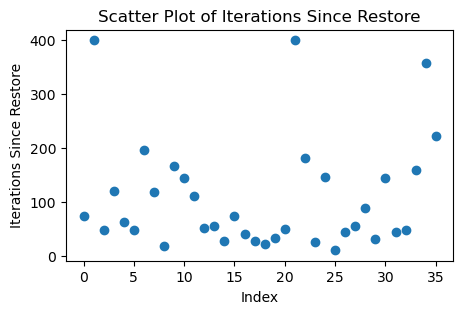

In [14]:
paths = [
    "/user/ml4723/Prj/NIC/ray_results/new_perf/ctx/5/run_2024-08-29_00-29-57/experiment_state-2024-08-29_00-29-58.json",
]
merged_results = merge_experiment_results(paths)

In [4]:
weekly_forecast_paths = {
    1: '/user/ml4723/Prj/NIC/ray_results/cons/weekly_forecast_NN',
}
data_driven_net_paths = {
    1: '/user/ml4723/Prj/NIC/ray_results/cons/data_driven_net',
}
fixed_quantile_paths = {
    1: '/user/ml4723/Prj/NIC/ray_results/cons/fixed_quantile',
}
quantile_nv_paths = {
    1: '/user/ml4723/Prj/NIC/ray_results/cons/quantile_nv',
}
just_in_time_paths = {
    1: '/user/ml4723/Prj/NIC/ray_results/cons/just_in_time',
}

#def custom_data_filler(out_row, reference_row):
#    out_row['path'] = reference_row['path']

results_interpretor = rri.RayResultsinterpreter()
df_weekly_forecast = results_interpretor.make_table(weekly_forecast_paths, {'store_underage_cost': [4, 6, 9, 13]})
df_data_driven_net = results_interpretor.make_table(data_driven_net_paths, {'store_underage_cost': [4, 6, 9, 13]})
df_fixed_quantile = results_interpretor.make_table(fixed_quantile_paths, {'store_underage_cost': [4, 6, 9, 13]})
df_quantile_nv = results_interpretor.make_table(quantile_nv_paths, {'store_underage_cost': [4, 6, 9, 13]})
df_just_in_time = results_interpretor.make_table(just_in_time_paths, {'store_underage_cost': [4, 6, 9, 13]})
df_weekly_forecast.insert(1, 'Architecture Class', "Weekly Forecast")
df_data_driven_net.insert(1, 'Architecture Class', "HDPO")
df_fixed_quantile.insert(1, 'Architecture Class', "Fixed Quantile")
df_quantile_nv.insert(1, 'Architecture Class', "Newsvendor")
df_just_in_time.insert(1, 'Architecture Class', "Oracle")

optimal_weeks = {
    4: 4.7298,
    6: 5.0385,
    9: 5.3489,
    13: 5.5832
}
df = pd.concat([df_weekly_forecast, df_data_driven_net, df_fixed_quantile, df_quantile_nv, df_just_in_time])

# Insert 'Optimal # of Weeks' next to 'Architecture Class' only for Weekly Forecast rows
architecture_class_index = df.columns.get_loc('Architecture Class')
df.insert(architecture_class_index + 1, 'Optimal # of Weeks', None)
df.loc[df['Architecture Class'] == 'Weekly Forecast', 'Optimal # of Weeks'] = df.loc[df['Architecture Class'] == 'Weekly Forecast', 'store_underage_cost'].map(optimal_weeks)

min_dev_loss = df.groupby(['store_underage_cost'])['Dev Loss'].transform('min')
df['Dev Gap %'] = -((df['Dev Loss'] - min_dev_loss) / min_dev_loss) * 100
df.insert(df.columns.get_loc(df.columns[-2]), 'Dev Gap %', df.pop('Dev Gap %'))
df.drop(columns=['# of stores', '# of runs'], inplace=True)
# Define the custom order for Architecture Class
architecture_order = ['Oracle', 'HDPO', 'Weekly Forecast', 'Fixed Quantile', 'Newsvendor']
# Create a categorical column with the custom order
df['Architecture Class'] = pd.Categorical(df['Architecture Class'], categories=architecture_order, ordered=True)
# Sort the dataframe
df.sort_values(by=['store_underage_cost', 'Architecture Class'], inplace=True)
# Move store_underage_cost to the first column
cols = df.columns.tolist()
cols.remove('store_underage_cost')
cols = ['store_underage_cost'] + cols
df = df[cols]

print(df.to_string(index=False))
df.to_csv('results.csv', index=False)
print("Results saved to comparison_results.csv")

 store_underage_cost Architecture Class Optimal # of Weeks  Train Loss    Dev Loss  Dev Gap %
                   4             Oracle               None -213.665006 -198.463167   0.000000
                   4               HDPO               None -161.395985 -150.136966  24.350211
                   4    Weekly Forecast             4.7298 -144.881375 -134.072153  32.444819
                   4     Fixed Quantile               None -150.145288 -139.585469  29.666814
                   4         Newsvendor               None -134.674537 -120.307394  39.380493
                   6             Oracle               None -320.510398 -297.704852   0.000000
                   6               HDPO               None -255.922236 -236.749878  20.474968
                   6    Weekly Forecast             5.0385 -238.705123 -220.377574  25.974477
                   6     Fixed Quantile               None -243.081326 -225.572379  24.229526
                   6         Newsvendor               None -

In [41]:
ctx_paths = {
    50: '/user/ml4723/Prj/NIC/ray_results/stable_bench_sample_efficiency/ctx/50',
}
gnn_paths = {
    50: '/user/ml4723/Prj/NIC/ray_results/stable_bench_sample_efficiency/GNN/50',
}
def custom_data_filler(out_row, reference_row):
    out_row['best_test_loss'] = reference_row['best_test_loss']
    pass
    # out_row['best_train_loss'] = reference_row['best_train_loss']
    #out_row['path'] = reference_row['path']
results_interpretor = rri.RayResultsinterpreter()
df_ctx = results_interpretor.make_table(ctx_paths, {'context': [1, 2, 4, 8, 16, 32, 64], 'samples': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12], 'learning_rate': [0.1, 0.01, 0.001, 0.0001]}, custom_data_filler, sort_by='best_test_loss')
df_ctx.rename(columns={'context': 'context size'}, inplace=True)

df_gnn = results_interpretor.make_table(gnn_paths, {'for_all_networks': [1, 2, 4, 8, 16, 32, 64], 'samples': [1, 2, 3, 4, 5], 'learning_rate': [0.1, 0.01, 0.001, 0.0001]}, custom_data_filler, sort_by='best_test_loss')
df_gnn.rename(columns={'for_all_networks': 'context size'}, inplace=True)

df_ctx.insert(1, 'Architecture Class', "Symmatry_Aware")
df_gnn.insert(1, 'Architecture Class', "GNN")
# df = pd.concat([df_ctx, df_gnn, df_gnn_mp, df_custom_stemb, df_vanilla])
df = pd.concat([df_ctx])

# Move 'master size' column next to 'context size'
if 'master' in df.columns:
    context_size_index = df.columns.get_loc('context size')
    master_size = df.pop('master')
    df.insert(context_size_index + 1, 'master', master_size)

min_test_loss = df.groupby(['# of stores'])['best_test_loss'].transform('min')
df['Test Gap %'] = ((df['best_test_loss'] - min_test_loss) / min_test_loss) * 100
df.insert(df.columns.get_loc(df.columns[-2]), 'Test Gap %', df.pop('Test Gap %'))
# df.sort_values(by=['# of stores', 'context size', 'master'], inplace=True)
df.sort_values(by=['# of stores', 'context size'], inplace=True)

print(df.to_string(index=False))

 # of stores Architecture Class  context size  samples  learning_rate  Learning Rate  Train Loss   Dev Loss   Test Loss  # of runs   Test Gap %  best_test_loss
          50     Symmatry_Aware             8        1         0.0001         0.0001    5.650241   7.421216   10.879798          1    46.751336        8.233992
          50     Symmatry_Aware             8        1         0.0010         0.0010   49.578414  44.554602   41.513131          1   639.152508       41.472713
          50     Symmatry_Aware             8        1         0.0100         0.0100  288.772125  37.387215   34.642025          1   517.411742       34.642025
          50     Symmatry_Aware             8        2         0.0001         0.0001   18.192926  20.490166  119.765963          1   418.095789       29.069559
          50     Symmatry_Aware             8        2         0.0010         0.0010   11.473066  11.937699  148.274425          1   223.611793       18.157361
          50     Symmatry_Aware         

In [26]:
ctx_paths = {
    50: '/user/ml4723/Prj/NIC/ray_results/stable_bench/ctx/50',
}
gnn_paths = {
    50: '/user/ml4723/Prj/NIC/ray_results/stable_bench/GNN/50',
}
gnn_wistemb_paths = {
    50: '/user/ml4723/Prj/NIC/ray_results/stable_bench/GNN_WISTEMB/50',
}
gnn_pna_wistemb_paths = {
    50: '/user/ml4723/Prj/NIC/ray_results/stable_bench/GNN_PNA_WISTEMB/50',
}
gnn_pna_paths = {
    50: '/user/ml4723/Prj/NIC/ray_results/stable_bench/GNN_PNA/50',
}
gnn_mp_paths = {
    50: '/user/ml4723/Prj/NIC/ray_results/stable_bench/GNN_message_passing/50',
}
gnn_separation_paths = {
    50: '/user/ml4723/Prj/NIC/ray_results/stable_bench/GNN_Separation/50',
}
gnn_separation_pna_paths = {
    50: '/user/ml4723/Prj/NIC/ray_results/stable_bench/GNN_Separation_PNA/50',
}
vanilla_paths = {
    50: '/user/ml4723/Prj/NIC/ray_results/stable_bench/vanilla/50',
}
gnn_no_aggregation_paths = {
    50: '/user/ml4723/Prj/NIC/ray_results/stable_bench/GNN_No_Aggregation/50',
}

def custom_data_filler(out_row, reference_row):
    pass
    # out_row['best_train_loss'] = reference_row['best_train_loss']
    #out_row['path'] = reference_row['path']
results_interpretor = rri.RayResultsinterpreter()
df_ctx = results_interpretor.make_table(ctx_paths, {'context': [4, 8, 16, 32, 64]}, custom_data_filler)
df_ctx.rename(columns={'context': 'context size'}, inplace=True)

df_gnn = results_interpretor.make_table(gnn_paths, {'for_all_networks': [4, 8, 16, 32, 64]}, custom_data_filler)
df_gnn.rename(columns={'for_all_networks': 'context size'}, inplace=True)

df_gnn_wistemb = results_interpretor.make_table(gnn_wistemb_paths, {'for_all_networks': [4, 8, 16, 32, 64]}, custom_data_filler)
df_gnn_wistemb.rename(columns={'for_all_networks': 'context size'}, inplace=True)

df_gnn_pna_wistemb = results_interpretor.make_table(gnn_pna_wistemb_paths, {'for_all_networks': [4, 8, 16, 32, 64]}, custom_data_filler)
df_gnn_pna_wistemb.rename(columns={'for_all_networks': 'context size'}, inplace=True)

df_gnn_pna = results_interpretor.make_table(gnn_pna_paths, {'for_all_networks': [4, 8, 16, 32, 64]}, custom_data_filler)
df_gnn_pna.rename(columns={'for_all_networks': 'context size'}, inplace=True)

df_gnn_separation = results_interpretor.make_table(gnn_separation_paths, {'for_all_networks': [4, 8, 16, 32, 64]}, custom_data_filler)
df_gnn_separation.rename(columns={'for_all_networks': 'context size'}, inplace=True)

df_gnn_separation_pna = results_interpretor.make_table(gnn_separation_pna_paths, {'for_all_networks': [4, 8, 16, 32, 64]}, custom_data_filler)
df_gnn_separation_pna.rename(columns={'for_all_networks': 'context size'}, inplace=True)

df_gnn_mp = results_interpretor.make_table(gnn_mp_paths, {'context': [4, 8, 16, 32, 64]}, custom_data_filler)
df_gnn_mp.rename(columns={'context': 'context size'}, inplace=True)

df_vanilla = results_interpretor.make_table(vanilla_paths, {'master': [128, 512]}, custom_data_filler)

df_gnn_no_aggregation = results_interpretor.make_table(gnn_no_aggregation_paths, {'for_all_networks': [4, 8, 16, 32, 64]}, custom_data_filler)
df_gnn_no_aggregation.rename(columns={'for_all_networks': 'context size'}, inplace=True)

df_ctx.insert(1, 'Architecture Class', "Symmatry_Aware")
df_gnn.insert(1, 'Architecture Class', "GNN")
df_gnn_wistemb.insert(1, 'Architecture Class', "GNN_WISTEMB")
df_gnn_mp.insert(1, 'Architecture Class', "GNN_MP")
df_gnn_pna_wistemb.insert(1, 'Architecture Class', "GNN_PNA_WISTEMB")
df_gnn_pna.insert(1, 'Architecture Class', "GNN_PNA")
df_gnn_separation.insert(1, 'Architecture Class', "GNN_Separation")
df_gnn_separation_pna.insert(1, 'Architecture Class', "GNN_Separation_PNA")
df_vanilla.insert(1, 'Architecture Class', "Vanilla")
df_gnn_no_aggregation.insert(1, 'Architecture Class', "GNN_No_Aggregation")

# Concatenate all dataframes
# df = pd.concat([df_ctx, df_gnn, df_gnn_wistemb, df_gnn_mp, df_gnn_pna_wistemb, df_gnn_pna, 
#.                df_gnn_separation, df_gnn_separation_pna,, df_vanilla])
# df = pd.concat([df_ctx])
df = pd.concat([df_ctx, df_gnn, df_gnn_no_aggregation])

# Move 'master size' column next to 'context size'
if 'master' in df.columns:
    context_size_index = df.columns.get_loc('context size')
    master_size = df.pop('master')
    df.insert(context_size_index + 1, 'master', master_size)

#min_test_loss = df.groupby(['# of stores', 'context size'])['Test Loss'].transform('min')
min_test_loss = df.groupby(['# of stores'])['Test Loss'].transform('min')
df['Test Gap %(all)'] = ((df['Test Loss'] - min_test_loss) / min_test_loss) * 100
df.insert(df.columns.get_loc(df.columns[-2]), 'Test Gap %(all)', df.pop('Test Gap %(all)'))
min_test_loss = df.groupby(['# of stores', 'context size'])['Test Loss'].transform('min')
df['Test Gap %(context)'] = ((df['Test Loss'] - min_test_loss) / min_test_loss) * 100
df.insert(df.columns.get_loc(df.columns[-2]), 'Test Gap %(context)', df.pop('Test Gap %(context)'))
# df.sort_values(by=['# of stores', 'context size', 'master'], inplace=True)
df.sort_values(by=['# of stores', 'context size'], inplace=True)

print(df.to_string(index=False))

 # of stores Architecture Class  context size  Learning Rate  Train Loss  Dev Loss  Test Loss  Test Gap %(all)  Test Gap %(context)  # of runs
          50     Symmatry_Aware             4         0.0001    5.267518  5.246959   5.264585         0.751766             0.369205         18
          50                GNN             4         0.0010    5.273201  5.248708   5.270007         0.855535             0.472581         17
          50 GNN_No_Aggregation             4         0.0010    5.252612  5.228131   5.245219         0.381153             0.000000          9
          50     Symmatry_Aware             8         0.0001    5.255547  5.235310   5.252848         0.527160             0.264266         18
          50                GNN             8         0.0001    5.241436  5.221542   5.239004         0.262201             0.000000         18
          50 GNN_No_Aggregation             8         0.0001    6.770121  6.744790   6.909938        32.239961            31.894133          9

In [27]:
ctx_paths = {
    50: '/user/ml4723/Prj/NIC/ray_results/stable_bench_sample_efficiency/ctx/50',
}
gnn_paths = {
    50: '/user/ml4723/Prj/NIC/ray_results/stable_bench_sample_efficiency/GNN/50',
}
gnn_larger_stemb_paths = {
    50: '/user/ml4723/Prj/NIC/ray_results/stable_bench_sample_efficiency/GNN_larger_stemb/50',
}
gnn_relu_stemb_paths = {
    50: '/user/ml4723/Prj/NIC/ray_results/stable_bench_sample_efficiency/GNN_ReLU_stemb/50',
}
gnn_attention_paths = {
    50: '/user/ml4723/Prj/NIC/ray_results/stable_bench_sample_efficiency/GNN_attention/50',
}
gnn_pna_paths = {
    50: '/user/ml4723/Prj/NIC/ray_results/stable_bench_sample_efficiency/GNN_PNA/50',
}
vanilla_paths = {
    50: '/user/ml4723/Prj/NIC/ray_results/stable_bench_sample_efficiency/vanilla/50',
}

def custom_data_filler(out_row, reference_row):
    out_row['best_train_loss'] = reference_row['best_train_loss']
    pass
    # out_row['best_train_loss'] = reference_row['best_train_loss']
    #out_row['path'] = reference_row['path']
sort_by = 'test_loss'
training_n_samples = [1]
results_interpretor = rri.RayResultsinterpreter()
df_ctx = results_interpretor.make_table(ctx_paths, {'training_n_samples': training_n_samples, 'samples': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]}, custom_data_filler, sort_by=sort_by)
df_ctx.rename(columns={'context': 'context size'}, inplace=True)

df_gnn = results_interpretor.make_table(gnn_paths, {'training_n_samples': training_n_samples, 'samples': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]}, custom_data_filler, sort_by=sort_by)
df_gnn.rename(columns={'for_all_networks': 'context size'}, inplace=True)

df_gnn_larger_stemb = results_interpretor.make_table(gnn_larger_stemb_paths, {'training_n_samples': training_n_samples, 'samples': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]}, custom_data_filler, sort_by=sort_by)
df_gnn_larger_stemb.rename(columns={'for_all_networks': 'context size'}, inplace=True)

df_gnn_relu_stemb = results_interpretor.make_table(gnn_relu_stemb_paths, {'training_n_samples': training_n_samples, 'samples': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]}, custom_data_filler, sort_by=sort_by)
df_gnn_relu_stemb.rename(columns={'for_all_networks': 'context size'}, inplace=True)

df_gnn_attention = results_interpretor.make_table(gnn_attention_paths, {'samples': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]}, custom_data_filler, sort_by=sort_by)
df_gnn_attention['training_n_samples'] = training_n_samples[0]
df_gnn_attention.rename(columns={'for_all_networks': 'context size'}, inplace=True)

df_gnn_pna = results_interpretor.make_table(gnn_pna_paths, {'training_n_samples': training_n_samples, 'samples': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]}, custom_data_filler, sort_by=sort_by)
df_gnn_pna.rename(columns={'for_all_networks': 'context size'}, inplace=True)

df_vanilla = results_interpretor.make_table(vanilla_paths, {'training_n_samples': training_n_samples, 'samples': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]}, custom_data_filler, sort_by=sort_by)

df_ctx.insert(1, 'Architecture Class', "Symmatry_Aware")
df_gnn.insert(1, 'Architecture Class', "GNN")
df_gnn_attention.insert(1, 'Architecture Class', "GNN_Attention")
df_gnn_pna.insert(1, 'Architecture Class', "GNN_PNA")
df_gnn_relu_stemb.insert(1, 'Architecture Class', "GNN_ReLU_STEMB")
df_gnn_larger_stemb.insert(1, 'Architecture Class', "GNN_Larger_STEMB")
df_vanilla.insert(1, 'Architecture Class', "Vanilla")

# Concatenate all dataframes
# df = pd.concat([df_ctx, df_gnn, df_gnn_wistemb, df_gnn_mp, df_gnn_pna_wistemb, df_gnn_pna, 
#.                df_gnn_separation, df_gnn_separation_pna, df_vanilla])
# df = pd.concat([df_ctx])
df = pd.concat([df_ctx, df_gnn, df_gnn_attention, df_gnn_pna, df_gnn_relu_stemb, df_gnn_larger_stemb, df_vanilla])
df.drop(columns=['Dev Loss', 'Learning Rate', 'samples'], inplace=True)

df_avg = df.groupby(['# of stores', 'Architecture Class', 'training_n_samples']).agg({
    'Train Loss': 'mean',
    'Test Loss': 'mean',
    'best_train_loss': 'mean',
    '# of runs': 'sum'
}).reset_index()
df_avg = df_avg[['# of stores', 'Architecture Class', 'training_n_samples', 'Train Loss', 'Test Loss', '# of runs']]
df = df_avg

min_test_loss = 5.218509
df['Test Gap %'] = ((df['Test Loss'] - min_test_loss) / min_test_loss) * 100
df.insert(df.columns.get_loc(df.columns[-2]), 'Test Gap %', df.pop('Test Gap %'))
df.sort_values(by=['# of stores'], inplace=True)
df.rename(columns={'Train Loss': 'Train Loss(at best test loss)'}, inplace=True)
#df.drop(columns=['# of runs'], inplace=True)

print(df.to_string(index=False))

 # of stores Architecture Class  training_n_samples  Train Loss(at best test loss)  Test Loss  Test Gap %  # of runs
          50                GNN                   1                       5.538947   6.432312   23.259580        360
          50      GNN_Attention                   1                       5.448897   5.751466   10.212819        648
          50   GNN_Larger_STEMB                   1                       4.947377   6.359499   21.864285        324
          50      GNN_NoCtx_PNA                   1                       6.747120   7.348398   40.814133        108
          50            GNN_PNA                   1                       5.321012   6.353386   21.747159        360
          50     GNN_ReLU_STEMB                   1                       4.958621   6.475248   24.082342        324
          50     Symmatry_Aware                   1                       4.379046   5.959442   14.198182        360
          50            Vanilla                   1             

In [5]:
ctx_paths = {
    50: '/user/ml4723/Prj/NIC/ray_results/stable_bench_sample_efficiency/ctx/50',
}
gnn_paths = {
    50: '/user/ml4723/Prj/NIC/ray_results/stable_bench_sample_efficiency/GNN/50',
}
gnn_larger_stemb_paths = {
    50: '/user/ml4723/Prj/NIC/ray_results/stable_bench_sample_efficiency/GNN_larger_stemb/50',
}
gnn_relu_stemb_paths = {
    50: '/user/ml4723/Prj/NIC/ray_results/stable_bench_sample_efficiency/GNN_ReLU_stemb/50',
}
gnn_attention_paths = {
    50: '/user/ml4723/Prj/NIC/ray_results/stable_bench_sample_efficiency/GNN_attention/50',
}
gnn_pna_paths = {
    50: '/user/ml4723/Prj/NIC/ray_results/stable_bench_sample_efficiency/GNN_PNA/50',
}
vanilla_paths = {
    50: '/user/ml4723/Prj/NIC/ray_results/stable_bench_sample_efficiency/vanilla/50',
}

def custom_data_filler(out_row, reference_row):
    pass
    # out_row['best_train_loss'] = reference_row['best_train_loss']
    #out_row['path'] = reference_row['path']
sort_by = 'train_loss'
results_interpretor = rri.RayResultsinterpreter()
df_ctx = results_interpretor.make_table(ctx_paths, {'training_n_samples': [1], 'samples': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]}, custom_data_filler, sort_by=sort_by)
df_ctx.rename(columns={'context': 'context size'}, inplace=True)

df_gnn = results_interpretor.make_table(gnn_paths, {'training_n_samples': [1], 'samples': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]}, custom_data_filler, sort_by=sort_by)
df_gnn.rename(columns={'for_all_networks': 'context size'}, inplace=True)

df_gnn_larger_stemb = results_interpretor.make_table(gnn_larger_stemb_paths, {'training_n_samples': [1], 'samples': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]}, custom_data_filler, sort_by=sort_by)
df_gnn_larger_stemb.rename(columns={'for_all_networks': 'context size'}, inplace=True)

df_gnn_relu_stemb = results_interpretor.make_table(gnn_relu_stemb_paths, {'training_n_samples': [1], 'samples': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]}, custom_data_filler, sort_by=sort_by)
df_gnn_relu_stemb.rename(columns={'for_all_networks': 'context size'}, inplace=True)

df_gnn_attention = results_interpretor.make_table(gnn_attention_paths, {'samples': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]}, custom_data_filler, sort_by=sort_by)
df_gnn_attention['training_n_samples'] = 1
df_gnn_attention.rename(columns={'for_all_networks': 'context size'}, inplace=True)

df_gnn_pna = results_interpretor.make_table(gnn_pna_paths, {'training_n_samples': [1], 'samples': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]}, custom_data_filler, sort_by=sort_by)
df_gnn_pna.rename(columns={'for_all_networks': 'context size'}, inplace=True)

df_vanilla = results_interpretor.make_table(vanilla_paths, {'training_n_samples': [1], 'samples': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]}, custom_data_filler, sort_by=sort_by)

df_ctx.insert(1, 'Architecture Class', "Symmatry_Aware")
df_gnn.insert(1, 'Architecture Class', "GNN")
df_gnn_attention.insert(1, 'Architecture Class', "GNN_Attention")
df_gnn_pna.insert(1, 'Architecture Class', "GNN_PNA")
df_gnn_relu_stemb.insert(1, 'Architecture Class', "GNN_ReLU_STEMB")
df_gnn_larger_stemb.insert(1, 'Architecture Class', "GNN_Larger_STEMB")
df_vanilla.insert(1, 'Architecture Class', "Vanilla")

# Concatenate all dataframes
# df = pd.concat([df_ctx, df_gnn, df_gnn_wistemb, df_gnn_mp, df_gnn_pna_wistemb, df_gnn_pna, 
#.                df_gnn_separation, df_gnn_separation_pna, df_vanilla])
# df = pd.concat([df_ctx])
df = pd.concat([df_ctx, df_gnn, df_gnn_pna, df_gnn_attention, df_gnn_relu_stemb, df_gnn_larger_stemb, df_vanilla])
df.drop(columns=['Test Loss', 'Dev Loss', 'Learning Rate', 'samples'], inplace=True)

df_avg = df.groupby(['# of stores', 'Architecture Class', 'training_n_samples']).agg({
    'Train Loss': 'mean',
    '# of runs': 'sum'
}).reset_index()
df_avg = df_avg[['# of stores', 'Architecture Class', 'training_n_samples', 'Train Loss', '# of runs']]
df = df_avg
#df.drop(columns=['# of runs'], inplace=True)

print(df.to_string(index=False))

 # of stores Architecture Class  training_n_samples  Train Loss  # of runs
          50                GNN                   1    4.560037        360
          50      GNN_Attention                   1    4.619906        324
          50   GNN_Larger_STEMB                   1    4.625154        324
          50      GNN_NoCtx_PNA                   1    4.351136        108
          50            GNN_PNA                   1    4.463108        360
          50     GNN_ReLU_STEMB                   1    4.644932        324
          50     Symmatry_Aware                   1    3.664529        360
          50            Vanilla                   1    2.990698        216


store primitives fixed over samples. n_samples = 416
                     Architecture Class  store_underage_cost  Learning Rate  Train Loss    Dev Loss  Dev Gap %  # of runs
                         GNN_Normalized                    4          0.010 -179.937077 -161.550322      24.49         30
                           Just_In_Time                    4            NaN -233.280130 -213.940328       0.00          1
Symmatry_Aware_Decentralized_Normalized                    4          0.010 -177.936243 -160.941777      24.77         30
              Symmatry_Aware_Normalized                    4          0.010 -185.411727 -157.062500      26.59         30
                                Vanilla                    4          0.001 -179.857190 -154.497419      27.78         30
                     Vanilla_Normalized                    4          0.001 -180.008454 -154.405402      27.83         30
                         GNN_Normalized                    6          0.010 -282.843067 -253.

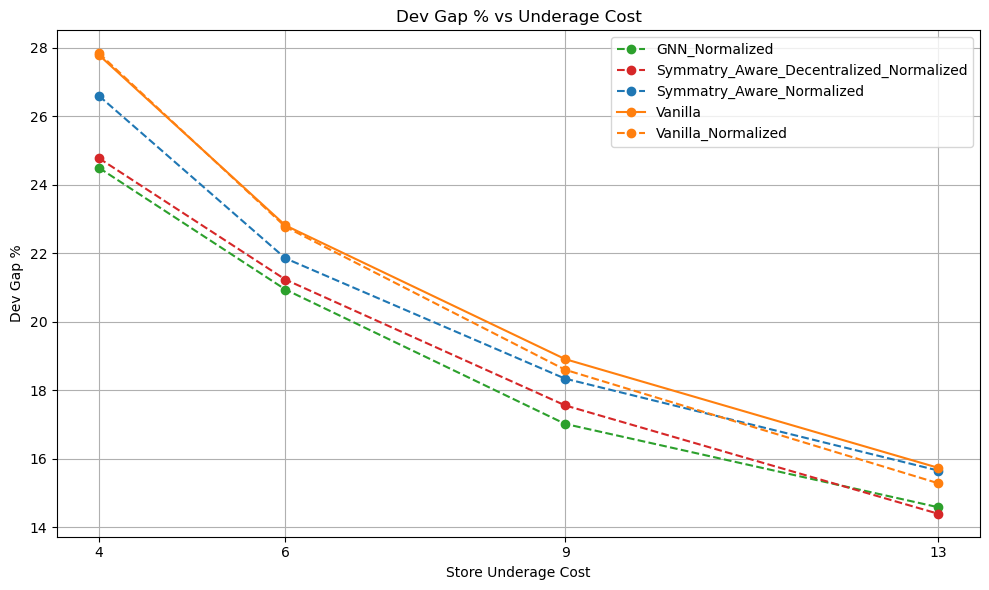

In [13]:
sort_by = 'dev_loss'
pick_row_from_run_by = 'dev_loss'
def custom_data_filler(out_row, reference_row):
    pass

real_path = 'warehouse_real_fixed_stores'
# real_path = 'warehouse_real'

symmetry_aware_paths = {
    16: f'/user/ml4723/Prj/NIC/ray_results/{real_path}/symmetry_aware',
}
vanilla_paths = {
    16: f'/user/ml4723/Prj/NIC/ray_results/{real_path}/vanilla',
}
gnn_paths = {
    16: f'/user/ml4723/Prj/NIC/ray_results/{real_path}/GNN',
}
symmetry_aware_decentralized_paths = {
    16: f'/user/ml4723/Prj/NIC/ray_results/{real_path}/symmetry_aware_decentralized',
}
just_in_time_paths = {
    16: f'/user/ml4723/Prj/NIC/ray_results/{real_path}/just_in_time',
}
# transformed_nv_paths = {
#     16: f'/user/ml4723/Prj/NIC/ray_results/{real_path}/transformed_nv',
# }

# Add normalized paths
symmetry_aware_normalized_paths = {
    16: f'/user/ml4723/Prj/NIC/ray_results/{real_path}/symmetry_aware_normalized',
}
vanilla_normalized_paths = {
    16: f'/user/ml4723/Prj/NIC/ray_results/{real_path}/vanilla_normalized',
}
gnn_normalized_paths = {
    16: f'/user/ml4723/Prj/NIC/ray_results/{real_path}/GNN_normalized',
}
symmetry_aware_decentralized_normalized_paths = {
    16: f'/user/ml4723/Prj/NIC/ray_results/{real_path}/symmetry_aware_decentralized_normalized',
}

store_underage_cost = [4, 6, 9, 13]
results_interpretor = rri.RayResultsinterpreter()
df_symmetry_aware = results_interpretor.make_table(symmetry_aware_paths, {'store_underage_cost': store_underage_cost, 'training_n_samples': [416]}, custom_data_filler, sort_by=sort_by, pick_row_from_run_by=pick_row_from_run_by)
df_vanilla = results_interpretor.make_table(vanilla_paths, {'store_underage_cost': store_underage_cost, 'training_n_samples': [416]}, custom_data_filler, sort_by=sort_by, pick_row_from_run_by=pick_row_from_run_by)
df_gnn = results_interpretor.make_table(gnn_paths, {'store_underage_cost': store_underage_cost, 'training_n_samples': [416]}, custom_data_filler, sort_by=sort_by, pick_row_from_run_by=pick_row_from_run_by)
df_symmetry_aware_decentralized = results_interpretor.make_table(symmetry_aware_decentralized_paths, {'store_underage_cost': store_underage_cost, 'training_n_samples': [416]}, custom_data_filler, sort_by=sort_by, pick_row_from_run_by=pick_row_from_run_by)
df_just_in_time = results_interpretor.make_table(just_in_time_paths, {'store_underage_cost': store_underage_cost}, custom_data_filler, sort_by=sort_by, pick_row_from_run_by=pick_row_from_run_by)

df_symmetry_aware.insert(1, 'Architecture Class', "Symmatry_Aware")
df_vanilla.insert(1, 'Architecture Class', "Vanilla")
df_gnn.insert(1, 'Architecture Class', "GNN")
df_symmetry_aware_decentralized.insert(1, 'Architecture Class', "Symmatry_Aware_Decentralized")
df_just_in_time.insert(1, 'Architecture Class', "Just_In_Time")

# Add normalized versions
df_symmetry_aware_normalized = results_interpretor.make_table(symmetry_aware_normalized_paths, {'store_underage_cost': store_underage_cost, 'training_n_samples': [416]}, custom_data_filler, sort_by=sort_by, pick_row_from_run_by=pick_row_from_run_by)
df_vanilla_normalized = results_interpretor.make_table(vanilla_normalized_paths, {'store_underage_cost': store_underage_cost, 'training_n_samples': [416]}, custom_data_filler, sort_by=sort_by, pick_row_from_run_by=pick_row_from_run_by)
df_gnn_normalized = results_interpretor.make_table(gnn_normalized_paths, {'store_underage_cost': store_underage_cost, 'training_n_samples': [416]}, custom_data_filler, sort_by=sort_by, pick_row_from_run_by=pick_row_from_run_by)
df_symmetry_aware_decentralized_normalized = results_interpretor.make_table(symmetry_aware_decentralized_normalized_paths, {'store_underage_cost': store_underage_cost, 'training_n_samples': [416]}, custom_data_filler, sort_by=sort_by, pick_row_from_run_by=pick_row_from_run_by)

df_symmetry_aware_normalized.insert(1, 'Architecture Class', "Symmatry_Aware_Normalized")
df_vanilla_normalized.insert(1, 'Architecture Class', "Vanilla_Normalized")
df_gnn_normalized.insert(1, 'Architecture Class', "GNN_Normalized")
df_symmetry_aware_decentralized_normalized.insert(1, 'Architecture Class', "Symmatry_Aware_Decentralized_Normalized")

# df_fixed = pd.concat([df_symmetry_aware, df_vanilla, df_gnn, df_symmetry_aware_decentralized, df_just_in_time, df_transformed_nv,
#                       df_symmetry_aware_normalized, df_vanilla_normalized, df_gnn_normalized, df_symmetry_aware_decentralized_normalized])

df_fixed = pd.concat([df_vanilla, df_just_in_time, df_symmetry_aware_normalized, df_vanilla_normalized, df_gnn_normalized, df_symmetry_aware_decentralized_normalized])

# df_fixed = pd.concat([df_just_in_time, df_symmetry_aware_normalized, df_vanilla_normalized, df_gnn_normalized, df_symmetry_aware_decentralized_normalized])

min_dev_loss = df_fixed.groupby('store_underage_cost')['Dev Loss'].min()
df_fixed['Dev Gap %'] = df_fixed.apply(lambda row: ((row['Dev Loss'] - min_dev_loss[row['store_underage_cost']]) / min_dev_loss[row['store_underage_cost']]) * 100, axis=1)
df_fixed['Dev Gap %'] = df_fixed['Dev Gap %'].round(2) * -1

columns = df_fixed.columns.tolist()
runs_column = columns.pop(columns.index(('# of runs')))
df_fixed = df_fixed[columns + [runs_column]]
df_fixed = df_fixed.drop(['# of stores', 'training_n_samples'], axis=1)

df_fixed.sort_values(by=['store_underage_cost', 'Architecture Class'], inplace=True)
print('store primitives fixed over samples. n_samples = 416')
print(df_fixed.to_string(index=False))

# Define color scheme for architecture types
color_scheme = {
    "Symmatry_Aware": "#1f77b4",  # Blue
    "Vanilla": "#ff7f0e",  # Orange
    "GNN": "#2ca02c",  # Green
    "Symmatry_Aware_Decentralized": "#d62728",  # Red
    "Just_In_Time": "#9467bd",  # Purple
    "Transformed_NV": "#8c564b",  # Brown
    "Symmatry_Aware_Normalized": "#1f77b4",  # Blue (dashed)
    "Vanilla_Normalized": "#ff7f0e",  # Orange (dashed)
    "GNN_Normalized": "#2ca02c",  # Green (dashed)
    "Symmatry_Aware_Decentralized_Normalized": "#d62728",  # Red (dashed)
}

# Create the plot for fixed case
fig, ax = plt.subplots(figsize=(10, 6))

# Plot for Dev Gap %
pivot_df_fixed_dev = df_fixed.pivot(index='store_underage_cost', columns='Architecture Class', values='Dev Gap %')
for column in pivot_df_fixed_dev.columns:
    if 'Just_In_Time' in column:
        continue
    if 'Normalized' in column:
        linestyle = '--'
    else:
        linestyle = '-'
    ax.plot(pivot_df_fixed_dev.index, pivot_df_fixed_dev[column], marker='o', label=column, color=color_scheme[column], linestyle=linestyle)

ax.set_xlabel('Store Underage Cost')
ax.set_ylabel('Dev Gap %')
ax.set_title('Dev Gap % vs Underage Cost')
ax.legend()
ax.grid(True)
ax.set_xticks(pivot_df_fixed_dev.index)

plt.tight_layout()
plt.show()

store primitives fixed over samples. n_samples = 416
                     Architecture Class  store_underage_cost  Train Loss    Dev Loss  Learning Rate  Dev Gap %  # of runs
                         GNN_Normalized                    2  -73.647557  -69.061700          0.010      31.72         30
                           Just_In_Time                    2 -109.959408 -101.148358            NaN       0.00          1
Symmatry_Aware_Decentralized_Normalized                    2  -72.706062  -68.138592          0.010      32.63         30
              Symmatry_Aware_Normalized                    2  -76.073870  -67.469050          0.010      33.30         30
                     Vanilla_Normalized                    2  -74.042525  -65.274949          0.001      35.47         30
                         GNN_Normalized                    4 -166.746667 -152.289062          0.010      24.72         30
                           Just_In_Time                    4 -219.923500 -202.306932         

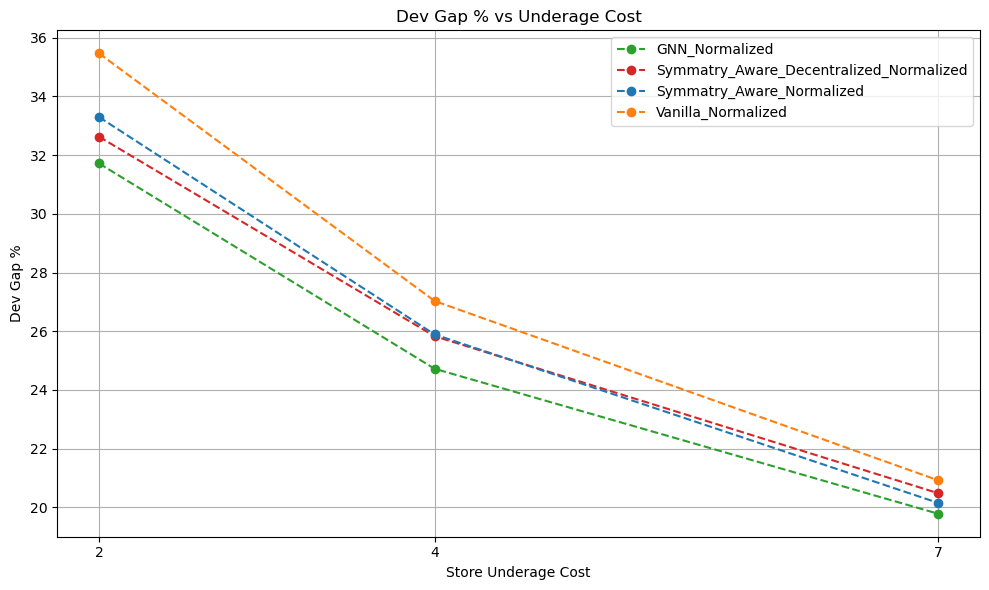

In [30]:
sort_by = 'dev_loss'
pick_row_from_run_by = 'dev_loss'
def custom_data_filler(out_row, reference_row):
    pass

real_path = 'warehouse_real_fixed_stores'

just_in_time_paths = {
    16: f'/user/ml4723/Prj/NIC/ray_results/{real_path}/just_in_time',
}

# Add normalized paths
symmetry_aware_normalized_paths = {
    16: f'/user/ml4723/Prj/NIC/ray_results/{real_path}/symmetry_aware_normalized',
}
vanilla_normalized_paths = {
    16: f'/user/ml4723/Prj/NIC/ray_results/{real_path}/vanilla_normalized',
}
gnn_normalized_paths = {
    16: f'/user/ml4723/Prj/NIC/ray_results/{real_path}/GNN_normalized',
}
symmetry_aware_decentralized_normalized_paths = {
    16: f'/user/ml4723/Prj/NIC/ray_results/{real_path}/symmetry_aware_decentralized_normalized',
}

store_underage_cost = [2, 4, 7]
results_interpretor = rri.RayResultsinterpreter()
df_just_in_time = results_interpretor.make_table(just_in_time_paths, {'store_underage_cost': store_underage_cost}, custom_data_filler, sort_by=sort_by, pick_row_from_run_by=pick_row_from_run_by)

# Add normalized versions
df_symmetry_aware_normalized = results_interpretor.make_table(symmetry_aware_normalized_paths, {'store_underage_cost': store_underage_cost, 'training_n_samples': [416]}, custom_data_filler, sort_by=sort_by, pick_row_from_run_by=pick_row_from_run_by)
df_vanilla_normalized = results_interpretor.make_table(vanilla_normalized_paths, {'store_underage_cost': store_underage_cost, 'training_n_samples': [416]}, custom_data_filler, sort_by=sort_by, pick_row_from_run_by=pick_row_from_run_by)
df_gnn_normalized = results_interpretor.make_table(gnn_normalized_paths, {'store_underage_cost': store_underage_cost, 'training_n_samples': [416]}, custom_data_filler, sort_by=sort_by, pick_row_from_run_by=pick_row_from_run_by)
df_symmetry_aware_decentralized_normalized = results_interpretor.make_table(symmetry_aware_decentralized_normalized_paths, {'store_underage_cost': store_underage_cost, 'training_n_samples': [416]}, custom_data_filler, sort_by=sort_by, pick_row_from_run_by=pick_row_from_run_by)

df_just_in_time.insert(1, 'Architecture Class', "Just_In_Time")
df_symmetry_aware_normalized.insert(1, 'Architecture Class', "Symmatry_Aware_Normalized")
df_vanilla_normalized.insert(1, 'Architecture Class', "Vanilla_Normalized")
df_gnn_normalized.insert(1, 'Architecture Class', "GNN_Normalized")
df_symmetry_aware_decentralized_normalized.insert(1, 'Architecture Class', "Symmatry_Aware_Decentralized_Normalized")

df_fixed = pd.concat([df_just_in_time, df_symmetry_aware_normalized, df_vanilla_normalized, df_gnn_normalized, df_symmetry_aware_decentralized_normalized])

min_dev_loss = df_fixed.groupby('store_underage_cost')['Dev Loss'].min()
df_fixed['Dev Gap %'] = df_fixed.apply(lambda row: ((row['Dev Loss'] - min_dev_loss[row['store_underage_cost']]) / min_dev_loss[row['store_underage_cost']]) * 100, axis=1)
df_fixed['Dev Gap %'] = df_fixed['Dev Gap %'].round(2) * -1

columns = df_fixed.columns.tolist()
runs_column = columns.pop(columns.index(('# of runs')))
df_fixed = df_fixed[columns + [runs_column]]
df_fixed = df_fixed.drop(['# of stores', 'training_n_samples'], axis=1)

df_fixed.sort_values(by=['store_underage_cost', 'Architecture Class'], inplace=True)
print('store primitives fixed over samples. n_samples = 416')
print(df_fixed.to_string(index=False))

# Define color scheme for architecture types
color_scheme = {
    "Just_In_Time": "#9467bd",  # Purple
    "Symmatry_Aware_Normalized": "#1f77b4",  # Blue (dashed)
    "Vanilla_Normalized": "#ff7f0e",  # Orange (dashed)
    "GNN_Normalized": "#2ca02c",  # Green (dashed)
    "Symmatry_Aware_Decentralized_Normalized": "#d62728",  # Red (dashed)
}

# Create the plot for fixed case
fig, ax = plt.subplots(figsize=(10, 6))

# Plot for Dev Gap %
pivot_df_fixed_dev = df_fixed.pivot(index='store_underage_cost', columns='Architecture Class', values='Dev Gap %')
for column in pivot_df_fixed_dev.columns:
    if 'Just_In_Time' in column:
        continue
    else:
        linestyle = '--'
    ax.plot(pivot_df_fixed_dev.index, pivot_df_fixed_dev[column], marker='o', label=column, color=color_scheme[column], linestyle=linestyle)

ax.set_xlabel('Store Underage Cost')
ax.set_ylabel('Dev Gap %')
ax.set_title('Dev Gap % vs Underage Cost')
ax.legend()
ax.grid(True)
ax.set_xticks(pivot_df_fixed_dev.index)

plt.tight_layout()
plt.show()

In [7]:
sort_by = 'train_loss'
pick_row_from_run_by = 'train_loss'
def custom_data_filler(out_row, reference_row):
    pass

symmetry_aware_paths = {
    16: '/user/ml4723/Prj/NIC/ray_results/warehouse_real/symmetry_aware',
}
vanilla_paths = {
    16: '/user/ml4723/Prj/NIC/ray_results/warehouse_real/vanilla',
}
gnn_paths = {
    16: '/user/ml4723/Prj/NIC/ray_results/warehouse_real/GNN',
}
symmetry_aware_decentralized_paths = {
    16: '/user/ml4723/Prj/NIC/ray_results/warehouse_real/symmetry_aware_decentralized',
}
just_in_time_paths = {
    16: '/user/ml4723/Prj/NIC/ray_results/warehouse_real/just_in_time',
}

store_underage_cost = [4, 6, 9, 13]
results_interpretor = rri.RayResultsinterpreter()
df_symmetry_aware = results_interpretor.make_table(symmetry_aware_paths, {'store_underage_cost': store_underage_cost}, custom_data_filler, sort_by=sort_by, pick_row_from_run_by=pick_row_from_run_by)

df_vanilla = results_interpretor.make_table(vanilla_paths, {'store_underage_cost': store_underage_cost}, custom_data_filler, sort_by=sort_by, pick_row_from_run_by=pick_row_from_run_by)

df_gnn = results_interpretor.make_table(gnn_paths, {'store_underage_cost': store_underage_cost}, custom_data_filler, sort_by=sort_by, pick_row_from_run_by=pick_row_from_run_by)

df_symmetry_aware_decentralized = results_interpretor.make_table(symmetry_aware_decentralized_paths, {'store_underage_cost': store_underage_cost}, custom_data_filler, sort_by=sort_by, pick_row_from_run_by=pick_row_from_run_by)

df_just_in_time = results_interpretor.make_table(just_in_time_paths, {'store_underage_cost': store_underage_cost}, custom_data_filler, sort_by=sort_by, pick_row_from_run_by=pick_row_from_run_by)

df_symmetry_aware.insert(1, 'Architecture Class', "Symmatry_Aware")
df_vanilla.insert(1, 'Architecture Class', "Vanilla")
df_gnn.insert(1, 'Architecture Class', "GNN")
df_symmetry_aware_decentralized.insert(1, 'Architecture Class', "Symmatry_Aware_Decentralized")
df_just_in_time.insert(1, 'Architecture Class', "Just_In_Time")
df_varied = pd.concat([df_symmetry_aware, df_vanilla, df_gnn, df_symmetry_aware_decentralized, df_just_in_time])

min_dev_loss = df_varied.groupby('store_underage_cost')['Dev Loss'].min()
df_varied['Dev Gap %'] = df_varied.apply(lambda row: ((row['Dev Loss'] - min_dev_loss[row['store_underage_cost']]) / min_dev_loss[row['store_underage_cost']]) * 100, axis=1)
df_varied['Dev Gap %'] = df_varied['Dev Gap %'].round(2) * -1
columns = df_varied.columns.tolist()
runs_column = columns.pop(columns.index(('# of runs')))
df_varied = df_varied[columns + [runs_column]]
df_varied = df_varied.drop('# of stores', axis=1)

df_varied.sort_values(by=['store_underage_cost'], inplace=True)
print('store primitives varied over samples. n_samples = 416')
print(df_varied.to_string(index=False))

store primitives varied over samples. n_samples = 416
          Architecture Class  store_underage_cost  Learning Rate  Train Loss    Dev Loss  Dev Gap %  # of runs
              Symmatry_Aware                    4         0.0010 -179.962959 -113.325721      43.98         18
                Just_In_Time                    4            NaN -219.923500 -202.306932       0.00          1
                     Vanilla                    4         0.0010 -178.547640 -130.603242      35.44         18
Symmatry_Aware_Decentralized                    4         0.0001 -158.259465 -137.188472      32.19         18
                         GNN                    4         0.0001 -165.606643 -144.714331      28.47         18
                Just_In_Time                    6            NaN -329.887538 -303.465392       0.00          1
Symmatry_Aware_Decentralized                    6         0.0010 -257.128114 -222.519973      26.67         18
                         GNN                    6         

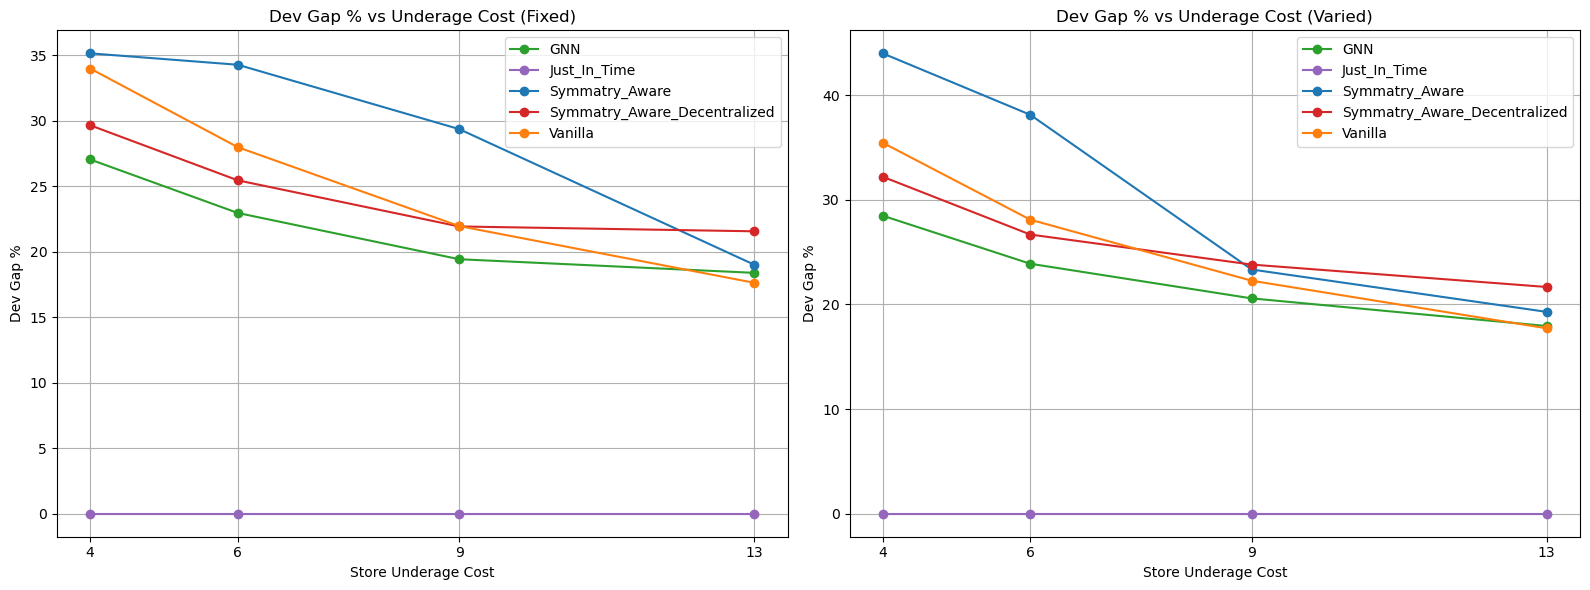

In [8]:
# Create the two side-by-side plots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
# Plot for df_fixed
pivot_df_fixed = df_fixed.pivot(index='store_underage_cost', columns='Architecture Class', values='Dev Gap %')
for column in pivot_df_fixed.columns:
    ax1.plot(pivot_df_fixed.index, pivot_df_fixed[column], marker='o', label=column, color=color_scheme[column])
ax1.set_xlabel('Store Underage Cost')
ax1.set_ylabel('Dev Gap %')
ax1.set_title('Dev Gap % vs Underage Cost (Fixed)')
ax1.legend()
ax1.grid(True)
ax1.set_xticks(pivot_df_fixed.index)

# Plot for df_varied
pivot_df_varied = df_varied.pivot(index='store_underage_cost', columns='Architecture Class', values='Dev Gap %')
for column in pivot_df_varied.columns:
    ax2.plot(pivot_df_varied.index, pivot_df_varied[column], marker='o', label=column, color=color_scheme[column])
ax2.set_xlabel('Store Underage Cost')
ax2.set_ylabel('Dev Gap %')
ax2.set_title('Dev Gap % vs Underage Cost (Varied)')
ax2.legend()
ax2.grid(True)
ax2.set_xticks(pivot_df_varied.index)

plt.tight_layout()
plt.show()
